In [2]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv
from scipy import optimize

## Burgers
$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
### experiment design

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 5, interval between cycles = 3 minutes(= every 4 steps)

4.obs mean = 0.0, obs stdv = 0.1, obs PDF = Gaussian

5.initial state = begin forecast 5 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = 1 cycle( 4 steps ))


In [3]:
# BURGERS MODEL
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l[1:-1] = -0.5 * (f[2:] - f[0:-2]) / dx \
        + nu / dx**2 * (u[2:] - 2 * u[1:-1] + u[0:-2])
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

In [11]:
def initialize():
    global u0, x, jmax, xmax, dx, dt, nu, dt_sec
    
    jmax = 81
    xmax = 2.0
    dx = 0.05
    dt = 0.0125
    dt_sec = dt*3600.0
    nu = 0.05
    x = np.arange(jmax)*dx - xmax
    u0 = np.zeros(jmax)
    u0[0] = 1.0
    print("nx={} nu={} dx={:7.3e} dt={:7.3e} dt_sec={:7.3e}".format(jmax, nu, dx, dt, dt_sec))

nx=81 nu=0.05 dx=5.000e-02 dt=1.250e-02 dt_sec=4.500e+01
Number of DA cycles = 5cycles, cycle interval = 3.0min., each cycle steps = 4steps, Number of observations = 81
fcst length = 20, incr_dt = 180.0sec.
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
cycle1
[1.00000000e+00 5.88761350e-01 2.31791183e-01 6.44403665e-02
 1.36901931e-02 2.18832543e-03 2.70003911e-04 2.20853380e-05
 1.20411696e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00

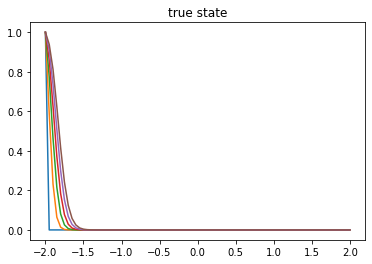

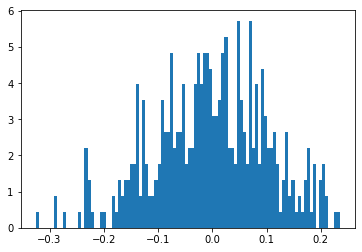

obs mean=-0.0034749048933676845, obs stdv=0.015490689929456625
obs mean=0.03639950750331873, obs stdv=0.01828605865864016
obs mean=0.01612028558212073, obs stdv=0.02744876513845716
obs mean=0.012367734954414763, obs stdv=0.026011084937290332
obs mean=0.052826926690151155, obs stdv=0.03438086661783178


In [36]:
### true state and obs
initialize()
N_cycles = 5
cycle_int = 3.0 #minutes
N_steps = int(cycle_int * 60. / dt_sec)
N_obs = jmax
print("Number of DA cycles = {}cycles, cycle interval = {}min., each cycle steps = {}steps, Number of observations = {}"
      .format(N_cycles, cycle_int, N_steps, N_obs))
obs_m = 0.0
obs_s = 0.1
yo = np.zeros((N_cycles,jmax)) # observation
## true
fcst_length = N_steps * N_cycles
incr_dt = cycle_int * 60.
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
ut = np.zeros((fcst_length+1,jmax))
# initialize
ut[0] = u0[:]
plt.plot(x,ut[0])
print(ut[0])
i = 0
for k in range(1,fcst_length+1):
    ut[k] = step(ut[k-1], dx, dt, nu)
    if (k%N_steps==0):
        yo[i] = ut[k]
        i += 1
        plt.plot(x,ut[k])
        print("cycle{}".format(int(k/N_steps)))
        print(ut[k])
plt.title("true state")
plt.show()

## observation
err = [random.normalvariate(obs_m, obs_s) for k in range(yo.size)]
oberr = np.array(err).reshape(yo.shape)
plt.hist(err,bins=100,density=True)
plt.show()
yo += oberr
for k in range(N_cycles):
    d = yo[k] - ut[int((k+1)/N_steps)]
    print("obs mean={}, obs stdv={}".format(np.mean(d), np.mean((d - np.mean(d))**2)))

fcst length = 40, incr_dt = 180.0sec.
cycle1
[1.00000000e+00 9.58029410e-01 8.66125145e-01 7.14587737e-01
 5.23883890e-01 3.38282169e-01 1.94170216e-01 1.00941753e-01
 4.84175822e-02 2.17170601e-02 9.18124238e-03 3.67343218e-03
 1.39361870e-03 5.01761185e-04 1.71521874e-04 5.56835638e-05
 1.71715101e-05 5.03081283e-06 1.40047202e-06 3.70471163e-07
 9.31295761e-08 2.22459145e-08 5.04870276e-09 1.08835369e-09
 2.22774909e-10 4.32772929e-11 7.97414111e-12 1.39253045e-12
 2.30258953e-13 3.60107225e-14 5.31949975e-15 7.41051193e-16
 9.71756179e-17 1.19687642e-17 1.38104376e-18 1.48837864e-19
 1.49280673e-20 1.38742718e-21 1.18872603e-22 9.32978575e-24
 6.65546283e-25 4.27274547e-26 2.43725863e-27 1.21433662e-28
 5.16024932e-30 1.80541386e-31 4.91238615e-33 9.34128487e-35
 9.49881094e-37 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

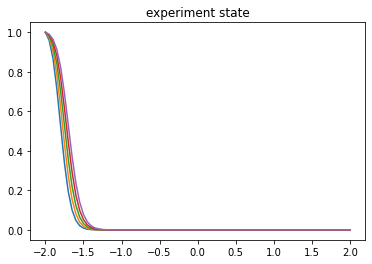

rmse no-obs
[0.1307804  0.11762074 0.10964497 0.10418721 0.10019955]


In [48]:
### No-observation experiment
N_cycle_shift = 5 #initial condition lag
fcst_length = N_steps * ( N_cycles + N_cycle_shift )
incr_dt = cycle_int * 60.

print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
un = np.zeros((fcst_length+1,jmax))
# initialize
un[0] = u0[:]
for k in range(1,fcst_length+1):
    un[k] = step(un[k-1], dx, dt, nu)
    if (k/N_steps>N_cycle_shift and k%N_steps==0):
        plt.plot(x,un[k])
        print("cycle{}".format(int(k/N_steps-N_cycle_shift)))
        print(un[k])
plt.title("experiment state")
plt.show()

rmsen = np.zeros(N_cycles)
for i in range(N_cycles):
    ind_n = (i+1+N_cycle_shift)*N_steps
    ind_t = (i+1)*N_steps
    rmsen[i] = np.mean((un[ind_n]-ut[ind_t])**2)
rmsen = np.sqrt(rmsen)
print("rmse no-obs")
print(rmsen)

In [154]:
### MLEF code
def Analysis(Xfc,Xf,dXf,y,sig,m,N,a,mask):
    #N = 40
    p = N-a
    R = np.eye(p)*sig
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    z = R_sqrt@H(Xf,mask) - R_sqrt@H(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    #z = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C)^(-1/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,H)
    res = optimize.minimize(J, zeta0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-8, 'disp':True})
    zeta = res.x
    jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    #zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    Xf = Xac.reshape(-1,1)+dXf
    z_opt = R_sqrt@H(Xf,mask)- R_sqrt@H(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    #z_opt = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin

def J(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
    
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask)   
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs = args
    B = A.T@A #(I+C)^(-1)
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    inv = y - H_obs(x,mask)
    ## modified
    djo = A.T@z.T@R_sqrt@inv
    #djo = z.T@R_sqrt@inv
    return B@zeta - djo

In [41]:
### observation operator (y=x)
def H(x,mask):
    xo = np.delete(x,mask,axis=0)
    return xo

fcst length = 16, incr_dt = 180.0sec.


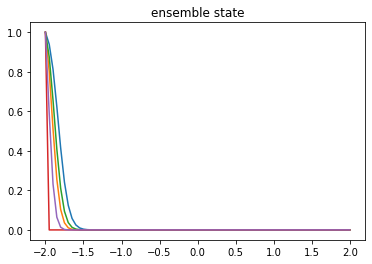

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.62136479e-02 -2.59553354e-02 -3.83310422e-01 -1.42949607e-01]
 [-1.23473096e-01 -6.36101671e-02 -3.31582863e-01 -2.36954508e-01]
 [-1.50256436e-01 -8.77647700e-02 -2.54560995e-01 -2.28253326e-01]
 [-1.27299421e-01 -8.32325429e-02 -1.69812767e-01 -1.64223769e-01]
 [-8.39926951e-02 -6.01262230e-02 -9.86497627e-02 -9.77563825e-02]
 [-4.64447251e-02 -3.57114074e-02 -5.08335889e-02 -5.07233603e-02]
 [-2.25948266e-02 -1.84098933e-02 -2.37503754e-02 -2.37413591e-02]
 [-9.96617348e-03 -8.52058227e-03 -1.02347798e-02 -1.02342882e-02]
 [-4.05534121e-03 -3.60808355e-03 -4.11042890e-03 -4.11042890e-03]
 [-1.53684963e-03 -1.41216422e-03 -1.54678896e-03 -1.54678896e-03]
 [-5.45203803e-04 -5.13768244e-04 -5.46772364e-04 -5.46772364e-04]
 [-1.81551720e-04 -1.74367979e-04 -1.81766515e-04 -1.81766515e-04]
 [-5.68333534e-05 -5.53435834e-05 -5.68585450e-05 -5.68585450e-05]
 [-1.67386784e-05 -1.64582857e-05 -1.67411649e-05 -1.67411649e

In [59]:
### ensemble initialize
mem = 4 # ensemble size
lag = N_steps
fcst_length = int(2 * lag * mem/2)
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
u1 = np.zeros((fcst_length+1,jmax))
u1[0] = u0[:]
for k in range(1,fcst_length+1):
    u1[k] = step(u1[k-1], dx, dt, nu)
## control
t_cntrl = N_cycle_shift * N_steps
uc0 = np.zeros(jmax)
uc0 = un[t_cntrl,:]
plt.plot(x,uc0)
ue0 = np.zeros((jmax,mem))
for imem in range(mem):
    ue0[:,imem] = u1[int((imem-mem/2)*lag)]
    plt.plot(x,ue0[:,imem])
plt.title("ensemble state")
plt.show()
sqrtPa0 = (ue0 - uc0.reshape(-1,1))/np.sqrt(2.0*(mem-1))
print(sqrtPa0)

In [63]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
##initialize
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        mask = np.random.choice(jmax,obsmiss,replace=False)
        (ue, Pa, ua[k], jmin) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask)
        trPa.append(np.mean(np.diag(Pa)))
    else:
        ua[k] = uf[k]
        ue = uef[:,:]

rmsea = np.zeros(N_cycles)
for i in range(N_cycles):
    ind_a = (i+1)*N_steps
    ind_t = (i+1)*N_steps
    rmsea[i] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmsea = np.sqrt(rmsea)
print("rmse analysis")
print(rmsea)
rmsef = np.zeros(N_cycles)
for i in range(N_cycles):
    ind_a = (i+1)*N_steps
    ind_t = (i+1)*N_steps
    rmsef[i] = np.mean((uf[ind_a]-ut[ind_t])**2)
rmsef = np.sqrt(rmsef)
print("rmse background")
print(rmsef)

print("error covariance")
print(trPa)

fcst length = 20, incr_dt = 180.0sec., obs miss = 0
Optimization terminated successfully.
         Current function value: 5.699674
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 3.914134
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 4.581959
         Iterations: 3
         Function evaluations: 38
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 4.717737
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 4.119579
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
rmse analysis
[0.01880446 0.01189783 0.00899365 0.00758192 0.00686956]
rmse background
[0.1307804  0.01400133 0.00972792 0.0077656  0.00680

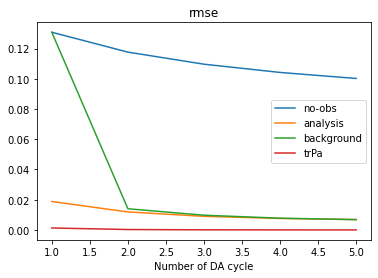

In [64]:
DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,rmsen,label="no-obs")
plt.plot(DAcycle,rmsea,label="analysis")
plt.plot(DAcycle,rmsef,label="background")
plt.plot(DAcycle,trPa[1:],label="trPa")
plt.xlabel("Number of DA cycle")
plt.title("rmse")
plt.legend()
plt.savefig("rmse-BURGERS.png")
plt.show()

### experiment design2 (Zupanski et al. 2008)

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 20, interval between cycles = 15 minutes(= every 20 steps)

4-1.quadratic obs
$ H(x) = x^2 (x \ge 0.5) , -x^2 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 8.0e-2, obs PDF = Gaussian

4-2.cubic obs
$ H(x) = x^3 (x \ge 0.5) , -x^3 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 7.0e-4, obs PDF = Gaussian

5.initial state = begin forecast 2 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = 1 cycle( 20 steps ))



In [155]:
### GRAD code
def Analysis_G(Xfc,Xf,dXf,y,sig,m,N,a,mask):
    #N = 40
    p = N-a
    R = np.eye(p)*sig
    I = np.eye(m)
    
    R_inv = np.linalg.inv(R)
    R_sqrt = np.sqrt(R_inv)
    #z = R_sqrt@H(Xf,mask) - R_sqrt@H(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@H_t(Xfc,dXf,mask)
    #z = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xfc,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C = z.T@z
    #print(C)
    
    la,v = np.linalg.eigh(C)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C)^(-T/2)
    
    zeta0 = np.zeros(m)
    args = (Xfc,dXf,A,y,R_inv,mask,H,H_t)
    res = optimize.minimize(J_G, zeta0, args=args, method='BFGS', jac=jacobi_G, options={'gtol':1e-8, 'disp':True})
    zeta = res.x
    jmin = res.fun
    #Pa_ = res.hess_inv #(I+C)^(-T/2)?
    #zeta,jmin = CG(zeta0,*args)
    Xac = Xfc + dXf@A@zeta
    
    #Xf = Xac.reshape(-1,1)+dXf
    #z_opt = R_sqrt@H(Xf,mask)- R_sqrt@H(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z_opt = R_sqrt@H_t(Xac,dXf,mask)
    #z_opt = R_sqrt@H2(Xf,mask) - R_sqrt@H2(Xac,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    C_opt = z_opt.T@z_opt
    
    la,v = np.linalg.eigh(C_opt)
    #print(v)
    D = np.diag(1/np.sqrt(la+np.ones(m)))
    #print(D)
    #V = np.array(v).reshape(m,m)
    A = v @ D @ v.T #(I+C_opt)^(-T/2)
    #print(A)
    
    dXa = dXf@A #Pf^(1/2)(I+C_opt)^(-T/2)
    
    Xa = np.zeros((N,m))
    Xa = dXa + Xac.reshape(-1,1)
    Pa = dXa@dXa.T
    
    return Xa,Pa,Xac,jmin

def J_G(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs,Ht_obs = args
    B = A.T@A #(I+C)^(-1)
     
    x = xb + dXf@A@zeta
    inv = y - H_obs(x,mask)   
    return (zeta.T@B@zeta + inv.T@R_inv@inv)/2

def jacobi_G(zeta,*args):
    xb,dXf,A,y,R_inv,mask,H_obs,Ht_obs = args
    B = A.T@A #(I+C)^(-1)
    R_sqrt = np.sqrt(R_inv)
    
    x = xb + dXf@A@zeta
    #z = R_sqrt@H_obs(x.reshape(-1,1)+dXf,mask) - R_sqrt@H_obs(x,mask).reshape(-1,1) #R^(-1/2)HPf^(1/2)
    z = R_sqrt@Ht_obs(x,dXf,mask) #R^(-1/2)(dH/dx)Pf^(1/2)
    inv = y - H_obs(x,mask)
    ##modified
    djo = A.T@z.T@R_sqrt@inv
    #djo = z.T@R_sqrt@inv
    return B@zeta - djo

In [158]:
## quadratic obs
def H2(x,mask):
    xo = np.delete(x,mask,axis=0)
    y = xo**2
    y[xo<0.5] *= -1
    return y
def H2_t(x,dx,mask):
    xo = np.delete(x,mask,axis=0)
    dxo = np.delete(dx,mask,axis=0)
    sign = np.ones(xo.size)
    sign[xo<0.5] *= -1
    return 2.0*(sign*xo).reshape(-1,1)*dxo
obs_m = 0.0
obs_s = 8.0e-2 #quadratic

In [159]:
## cubic obs
def H3(x,mask):
    xo = np.delete(x,mask,axis=0)
    y = xo**3
    y[xo<0.5] *= -1
    return y
def H3_t(x,dx,mask):
    xo = np.delete(x,mask,axis=0)
    dxo = np.delete(dx,mask,axis=0)
    sign = np.ones(xo.size)
    sign[xo<0.5] *= -1
    return 3.0*(sign*xo*xo).reshape(-1,1)*dxo
obs_m = 0.0
obs_s = 7.0e-4 #cubic

[-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0.91 -0.9  -0.89
 -0.88 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78 -0.77
 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65
 -0.64 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54 -0.53
 -0.52 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41
 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29
 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17
 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05
 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07
  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19
  0.2   0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31
  0.32  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43
  0.44  0.45  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55
  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0

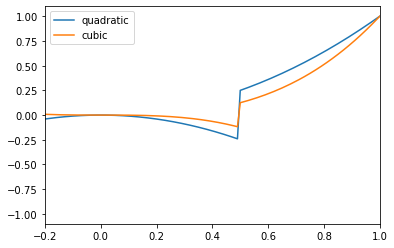

In [163]:
x_axis = np.linspace(-1.0,1.0,201)
#dx = np.ones(x.size).reshape(-1,1)*0.01
print(x_axis)
mask = np.random.choice(20,0,replace=False)
y2 = H2(x_axis,mask)
y3 = H3(x_axis,mask)
plt.plot(x_axis,y2,label="quadratic")
plt.plot(x_axis,y3,label="cubic")
plt.xlim([-0.2,1.0])
plt.legend()
plt.show()
#print(H_t(x,dx,mask))

In [148]:
def initialize():
    global u0, x, jmax, xmax, dx, dt, nu, dt_sec
    
    jmax = 81
    xmax = 2.0
    dx = 0.05
    dt = 0.0125
    dt_sec = dt*3600.0
    nu = 0.05
    x = np.arange(jmax)*dx - xmax
    u0 = np.zeros(jmax)
    u0[0] = 1.0
    dum = np.zeros(jmax)
    # initial state
    for k in range(40):
        dum = step(u0, dx, dt, nu)
        u0 = dum[:]
    plt.plot(x,u0)
    plt.title("initial state")
    plt.show()
    print("nx={} nu={} dx={:7.3e} dt={:7.3e} dt_sec={:7.3e}".format(jmax, nu, dx, dt, dt_sec))

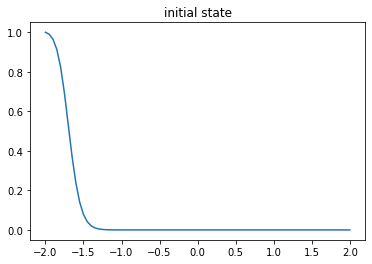

nx=81 nu=0.05 dx=5.000e-02 dt=1.250e-02 dt_sec=4.500e+01
Number of DA cycles = 20cycles, cycle interval = 15.0min., each cycle steps = 20steps, Number of observations = 81
fcst length = 400, incr_dt = 900.0sec.
[1.00000000e+00 9.89551766e-01 9.64332152e-01 9.12943022e-01
 8.23325101e-01 6.91853561e-01 5.32260231e-01 3.72328806e-01
 2.38035879e-01 1.40890357e-01 7.83472428e-02 4.14353201e-02
 2.10152930e-02 1.02718782e-02 4.85097001e-03 2.21608022e-03
 9.79758666e-04 4.19259099e-04 1.73649699e-04 6.96116177e-05
 2.70085830e-05 1.01424872e-05 3.68666563e-06 1.29719399e-06
 4.41876940e-07 1.45737479e-07 4.65441501e-08 1.43957113e-08
 4.31244332e-09 1.25135399e-09 3.51756866e-10 9.57951224e-11
 2.52759881e-11 6.46181058e-12 1.60062718e-12 3.84162579e-13
 8.93341931e-14 2.01268732e-14 4.39296400e-15 9.28788040e-16
 1.90193457e-16 3.77158299e-17 7.24129363e-18 1.34577859e-18
 2.42036625e-19 4.21121240e-20 7.08602738e-21 1.15265789e-21
 1.81180797e-22 2.75060762e-23 4.03103989e-24 5.69927232e

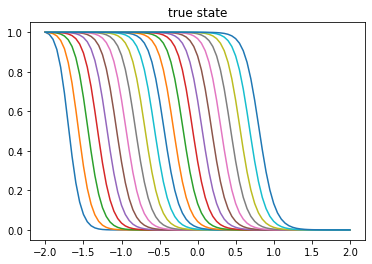

0.0 0.0007


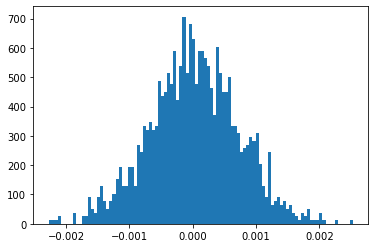

obs mean=-0.00019397658830550845, obs stdv=5.712382574097578e-07
obs mean=0.00010302954319752295, obs stdv=5.173030709840488e-07
obs mean=4.574548730192881e-05, obs stdv=4.7068041079854543e-07
obs mean=1.5827533212479025e-05, obs stdv=5.194114820858063e-07
obs mean=5.2156668089699204e-05, obs stdv=5.240837422868319e-07
obs mean=5.765756332131964e-07, obs stdv=5.543515189789179e-07
obs mean=0.0001146267591069974, obs stdv=6.910884005742188e-07
obs mean=6.503752836513774e-05, obs stdv=4.875914362619784e-07
obs mean=1.8300499044189413e-05, obs stdv=6.049993523933393e-07
obs mean=5.953685535209915e-05, obs stdv=4.531202502879985e-07
obs mean=8.458672750310591e-05, obs stdv=5.063091438520188e-07
obs mean=2.2668807702171643e-05, obs stdv=6.08291183854795e-07
obs mean=3.277903994040984e-05, obs stdv=3.0521888378460916e-07
obs mean=0.00010187398541421546, obs stdv=4.866607651625075e-07
obs mean=0.00011260967536415755, obs stdv=4.4106406337257287e-07
obs mean=-6.168899011329781e-06, obs stdv=4.

In [149]:
### true state and obs
initialize()
N_cycles = 20
cycle_int = 15.0 #minutes
N_steps = int(cycle_int * 60. / dt_sec)
N_obs = jmax
print("Number of DA cycles = {}cycles, cycle interval = {}min., each cycle steps = {}steps, Number of observations = {}"
      .format(N_cycles, cycle_int, N_steps, N_obs))

yo = np.zeros((N_cycles,N_obs)) # observation
mask = np.random.choice(jmax,jmax-N_obs,replace=False) # obsmiss
## true
fcst_length = N_steps * N_cycles
incr_dt = cycle_int * 60.
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
ut = np.zeros((fcst_length+1,jmax))
# initialize
ut[0] = u0[:]
plt.plot(x,ut[0])
print(ut[0])
i = 0
for k in range(1,fcst_length+1):
    ut[k] = step(ut[k-1], dx, dt, nu)
    if (k%N_steps==0):
        yo[i] = H(ut[k],mask)
        i += 1
        plt.plot(x,ut[k])
        print("cycle{}".format(int(k/N_steps)))
        print(ut[k])
plt.title("true state")
plt.show()

## observation
print(obs_m, obs_s)
err = [random.normalvariate(obs_m, obs_s) for k in range(yo.size)]
oberr = np.array(err).reshape(yo.shape)
plt.hist(err,bins=100,density=True)
plt.show()
yo += oberr
for k in range(N_cycles):
    d = yo[k] - H(ut[int((k+1)*N_steps)],mask)
    #print(d)
    print("obs mean={}, obs stdv={}".format(np.mean(d), np.mean((d - np.mean(d))**2)))

fcst length = 440, incr_dt = 900.0sec.
cycle1
[1.00000000e+00 9.99908672e-01 9.99678314e-01 9.99157250e-01
 9.98051136e-01 9.95805034e-01 9.91400100e-01 9.83026413e-01
 9.67619580e-01 9.40383346e-01 8.94776989e-01 8.23951650e-01
 7.24436924e-01 6.00695742e-01 4.66282606e-01 3.38772611e-01
 2.31882720e-01 1.51101835e-01 9.47838206e-02 5.77806019e-02
 3.44713147e-02 2.02200479e-02 1.16944707e-02 6.67926742e-03
 3.77007931e-03 2.10356506e-03 1.16020226e-03 6.32422591e-04
 3.40619995e-04 1.81219503e-04 9.52129056e-05 4.93894301e-05
 2.52883700e-05 1.27781734e-05 6.37091153e-06 3.13367352e-06
 1.52044191e-06 7.27618146e-07 3.43413036e-07 1.59837608e-07
 7.33611398e-08 3.32016670e-08 1.48165608e-08 6.51958794e-09
 2.82861351e-09 1.21005966e-09 5.10412945e-10 2.12286778e-10
 8.70597634e-11 3.52057942e-11 1.40385885e-11 5.52023136e-12
 2.14056655e-12 8.18562506e-13 3.08703424e-13 1.14818792e-13
 4.21194169e-14 1.52393288e-14 5.43850998e-15 1.91443770e-15
 6.64762339e-16 2.27704719e-16 7.694396

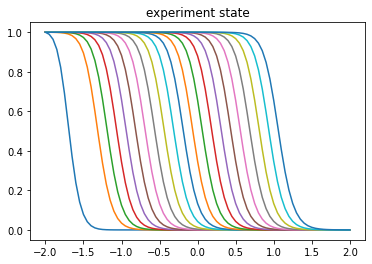

rmse no-obs
[0.16788967 0.16248934 0.15956811 0.15784898 0.15678619 0.15610811
 0.1556661  0.15537353 0.15517768 0.15504544 0.15495555 0.15489411
 0.15485193 0.15482286 0.15480277 0.15478885 0.15477917 0.15477244
 0.15476774 0.15476446 0.15476215]


In [150]:
### No-observation experiment
N_cycle_shift = 2 #initial condition lag
fcst_length = N_steps * ( N_cycles + N_cycle_shift )
incr_dt = cycle_int * 60.

print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
un = np.zeros((fcst_length+1,jmax))
# initialize
un[0] = u0[:]
plt.plot(x,un[0])
for k in range(1,fcst_length+1):
    un[k] = step(un[k-1], dx, dt, nu)
    if (k/N_steps>N_cycle_shift and k%N_steps==0):
        plt.plot(x,un[k])
        print("cycle{}".format(int(k/N_steps-N_cycle_shift)))
        print(un[k])
plt.title("experiment state")
plt.show()

rmsen = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_n = (i+N_cycle_shift)*N_steps
    ind_t = i*N_steps
    rmsen[i] = np.mean((un[ind_n]-ut[ind_t])**2)
rmsen = np.sqrt(rmsen)
print("rmse no-obs")
print(rmsen)

In [151]:
### ensemble initialize
def init_ens():
    global mem, uc0, ue0, sqrtPa0
    mem = 4 # ensemble size
    lag = N_steps#int(N_steps/2)

    ## control
    t_cntrl = N_cycle_shift * N_steps
    uc0 = np.zeros(jmax)
    uc0 = un[t_cntrl,:]
    #plt.plot(x,uc0)
    ue0 = np.zeros((jmax,mem))
    for imem in range(int(mem/2)):
        t_mem = t_cntrl - lag*(imem+1)
        ue0[:,2*imem] = un[t_mem,:]
        t_mem = t_cntrl + lag*(imem+1)
        ue0[:,2*imem+1] = un[t_mem,:]
    #for imem in range(mem):
    #    plt.plot(x,ue0[:,imem])
    #plt.title("ensemble state")
    #plt.show()
    sqrtPa0 = (ue0 - uc0.reshape(-1,1))#/np.sqrt(2.0*(mem-1))
    #print(sqrtPa0)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
         Current function value: 19.443986
         Iterations: 8
         Function evaluations: 53
         Gradient evaluations: 42
         Current function value: 12.860491
         Iterations: 3
         Function evaluations: 58
         Gradient evaluations: 46
         Current function value: 2.346751
         Iterations: 2
         Function evaluations: 38
         Gradient evaluations: 26
         Current function value: 2.205998
         Iterations: 2
         Function evaluations: 60
         Gradient evaluations: 48
         Current function value: 4.678654
         Iterations: 3
         Function evaluations: 90
         Gradient evaluations: 85
         Current function value: 1.046467
         Iterations: 2
         Function evaluations: 55
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: 0.906806
         Iterations: 3
         Function evaluations: 4
         Gr

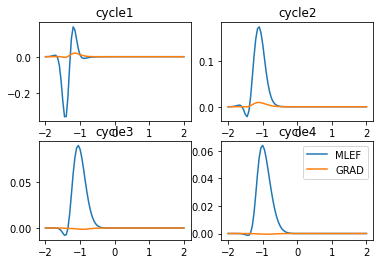

In [156]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

## MLEF
##initialize
init_ens()
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_m = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        mask = np.random.choice(jmax,obsmiss,replace=False)
        (ue, Pa, ua[k], jmin) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_m.append(jmin)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]

rmsea = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmsea[i] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmsea = np.sqrt(rmsea)

fig = plt.figure()
ax = []
for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax.append(fig.add_subplot(2, 2, i, title="cycle"+str(i)))
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="MLEF")


## GRAD
##initialize
init_ens()
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
trPa = []
Jmin_g = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        mask = np.random.choice(jmax,obsmiss,replace=False)
        (ue, Pa, ua[k], jmin) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask)
        trPa.append(np.mean(np.diag(Pa)))
        Jmin_g.append(jmin)
    else:
        ua[k] = uf[k]
        ue = uef[:,:]
rmseg = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmseg[i] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmseg = np.sqrt(rmseg)

for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="GRAD")
    
print("rmse MLEF")
print(rmsea)

print("rmse GRAD")
print(rmseg)

plt.legend()
plt.savefig("anl_err_c.png")
plt.show()
#print("error covariance")
#print(trPa)

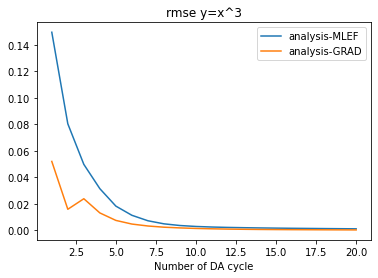

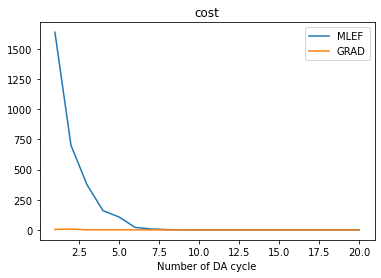

In [153]:
DAcycle = np.arange(1,N_cycles+1)
#plt.plot(DAcycle,rmsen,label="no-obs")
plt.plot(DAcycle,rmsea[1:],label="analysis-MLEF")
plt.plot(DAcycle,rmseg[1:],label="analysis-GRAD")
#plt.plot(DAcycle,rmsef,label="background")
#plt.plot(DAcycle,trPa[1:],label="trPa")
plt.xlabel("Number of DA cycle")
plt.title("rmse y=x^3")
plt.legend()
plt.savefig("rmse-BURGERS-mlef-grad_b.png")
plt.show()

DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,Jmin_m,label="MLEF")
plt.plot(DAcycle,Jmin_g,label="GRAD")
plt.xlabel("Number of DA cycle")
plt.title("cost")
plt.legend()
plt.savefig("cost-BURGERS-mlef-grad_b.png")
plt.show()